In [ ]:
# Connect to google drive from colab to obtain necessary data
# Uncomment if you use it in colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
import numpy as np

### Download images from the web to google drive. Use only one time.

In [3]:
df = pd.read_csv("/content/drive/My Drive/players_photos.csv", sep=";")
df.head()

,Team,Photo
0,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...
1,Avalanche,https://cms.nhl.bamgrid.com/images/arena/defau...
2,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...
3,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...
4,Avalanche,https://cms.nhl.bamgrid.com/images/actionshots...


In [4]:
PATH = "/content/drive/My Drive/players_photos/"

In [ ]:
# Loop for downloading images from the web and save it in google drive

for i in tqdm(range(df.shape[0])):
  r = requests.get(df.iloc[i, 1], stream=True)
  class_ = df.iloc[i, 0]
  if class_ not in os.listdir(PATH):
    os.mkdir(os.path.join(PATH, class_))
  photo_name = "player_" + f"{i}" + ".jpg"
  with open(os.path.join(PATH, class_, photo_name), "wb") as file:
    for block in r.iter_content(chunk_size = 1024): 
      if block:  
        file.write(block)

100%|██████████| 885/885 [03:32<00:00,  4.17it/s]


### Obtain id from the image name to connect to the team in original dataframe

In [5]:
def get_image_id(name):
  a = name.find("_")
  b = name.find(".")
  id = name[a+1:b]
  return int(id)

### Some data analysis

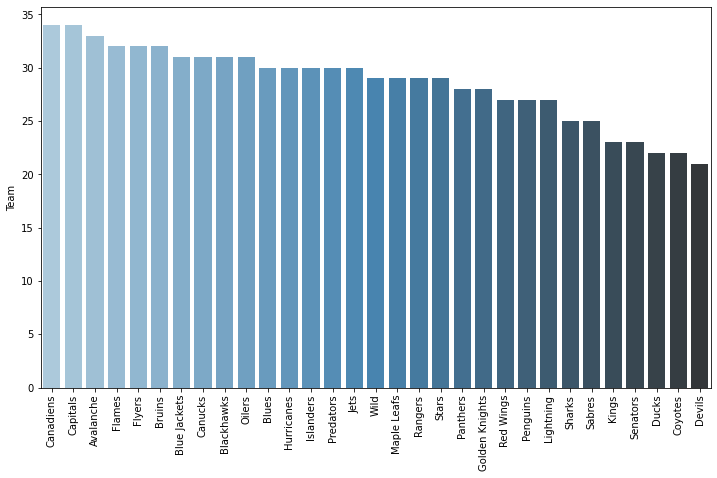

In [6]:
plt.figure(figsize=(12, 7))
sns.barplot(x=df.loc[:, "Team"].value_counts().index, 
            y=df.loc[:, "Team"].value_counts(),
            palette="Blues_d")
plt.xticks(rotation="vertical");

In [7]:
# Assign each team to certain value
# E.g. Avalanche: 0, Blackhawks: 1, ...
# And reverse
# It can be useful in future tasks

team_names_sorted_list = sorted(list(set(df.iloc[:,0])))
team_class_dict = dict()
reverse_team_class_dict = dict()
for i in tqdm(range(len(team_names_sorted_list))):
  team = team_names_sorted_list[i]
  class_ = i
  team_class_dict[team] = class_
  reverse_team_class_dict[class_] = team

100%|██████████| 31/31 [00:00<00:00, 111416.82it/s]


### 1. Prepare data

In [8]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

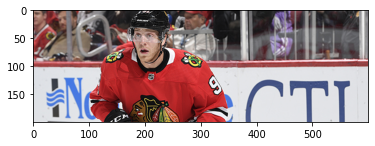

In [9]:
img = plt.imread("/content/drive/My Drive/players_photos/Blackhawks/player_33.jpg")
plt.imshow(img);

In [10]:
img.shape

(200, 600, 3)

#### datasets.ImageFolder approach of preparing data

In [11]:
# Check how datasets.ImageFolder works
data = datasets.ImageFolder(root=PATH)

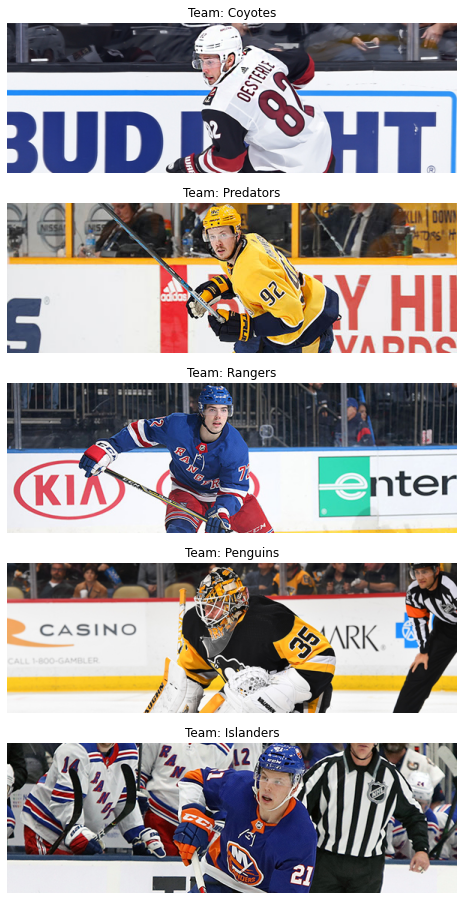

In [12]:
# Check image and assigning team
fig = plt.figure(figsize=(30, 16))
for i in range(5):
  data_point = np.random.randint(0, 885, 1)[0]
  pl = data[data_point]
  sub = fig.add_subplot(5, 1, i+1)
  sub.set_title(f"Team: {reverse_team_class_dict[pl[1]]}")
  plt.axis("off")
  plt.imshow(pl[0])
plt.show();

Looks fine... \
Create train and validation dataloaders (without transformation for now)

In [42]:
def get_train_and_valid_dataloaders(root, valid_size, batch_size, transformer=None):
  # Create train and validation datasets from root folder
  train_data = datasets.ImageFolder(root=root)
  valid_data = datasets.ImageFolder(root=root)

  # Get indices for train and valid data
  num = len(train_data)
  indices = list(range(num))
  split = int(valid_size * num)
  np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  # Create samplers for dataloaders
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  # Create train and valid dataloaders
  traindataloader = DataLoader(train_data, 
                                batch_size=batch_size,
                                sampler=train_sampler)
  
  validdataloader = DataLoader(valid_data, 
                                batch_size=batch_size,
                                sampler=valid_sampler)
  
  return traindataloader, validdataloader

In [43]:
train_dataloader, valid_dataloader = get_train_and_valid_dataloaders(PATH,
                                                                     valid_size=0.2,
                                                                     batch_size=16)

In [45]:
print(len(valid_dataloader.dataset.classes))

31


#### Standard pytorch approach

In [ ]:
# Create custom Dataset class for data handling
class NHLDataset(Dataset):
  # to be done